# 2D Vortex Decay in a Box

Goal: Simulate the decay of an initial vortex in a 2D square domain due to viscosity using the vorticity–streamfunction formulation.

---

## Governing Equations

Vorticity transport equation:

$$
\frac{\partial \omega}{\partial t} + \mathbf{u}\cdot\nabla \omega = \nu \nabla^2 \omega
$$

Poisson equation for streamfunction:

$$
\nabla^2 \psi = -\omega
$$

Velocity from streamfunction:

$$
u = \frac{\partial \psi}{\partial y}, \quad v = -\frac{\partial \psi}{\partial x}
$$

---

## Initial Condition

- Single vortex at the center:

$$
\omega(x,y,0) = \sin(\pi x) \sin(\pi y)
$$

- Boundary: No-slip walls (ψ=0) and vorticity computed from ψ at walls.

---

## Numerical Approach

- Grid: uniform Nx × Ny  
- Time stepping: explicit for vorticity  
- Poisson equation: solved via SOR  
- Visualization: streamfunction contours + velocity quiver plots  
- Observing vorticity decay over time due to viscosity

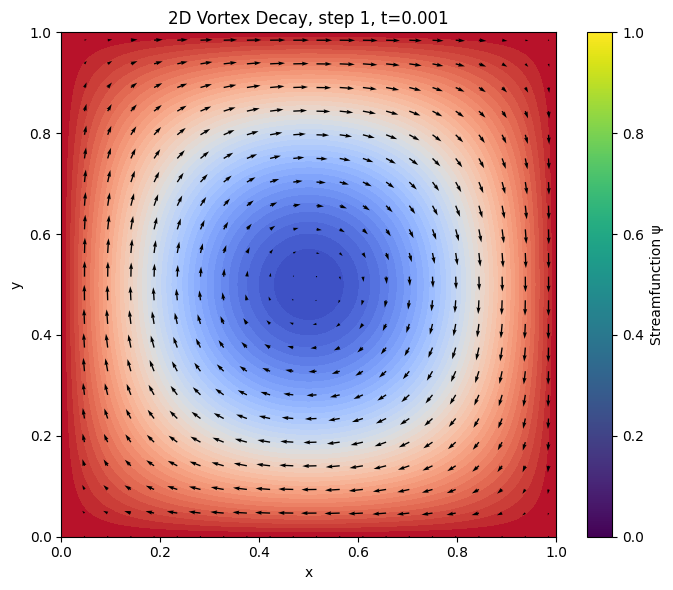

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# Parameters
# ---------------------------
Nx = 64
Ny = Nx
Lx = Ly = 1.0
dx = Lx / Nx
dy = Ly / Ny
nu = 0.01         # kinematic viscosity
dt = 0.001
nt = 1000
plot_every = 200
omega_relax = 1.7
poisson_tol = 1e-6
poisson_maxit = 5000

# Grid
x = np.linspace(0, Lx, Nx+1)
y = np.linspace(0, Ly, Ny+1)

# Initialize psi and omega
psi = np.zeros((Nx+1, Ny+1))
omega = np.sin(np.pi * x[:, None]) * np.sin(np.pi * y[None, :])

# ---------------------------
# Functions
# ---------------------------

def apply_vorticity_bc(omega, psi):
    # No-slip walls: ω = -2ψ_interior/dx^2 or dy^2
    omega[0, 1:-1] = -2*psi[1, 1:-1]/dx**2
    omega[-1,1:-1] = -2*psi[-2,1:-1]/dx**2
    omega[1:-1,0] = -2*psi[1:-1,1]/dy**2
    omega[1:-1,-1] = -2*psi[1:-1,-2]/dy**2
    # corners
    omega[0,0] = 0.5*(omega[1,0]+omega[0,1])
    omega[0,-1] = 0.5*(omega[1,-1]+omega[0,-2])
    omega[-1,0] = 0.5*(omega[-2,0]+omega[-1,1])
    omega[-1,-1] = 0.5*(omega[-2,-1]+omega[-1,-2])

def solve_poisson_SOR(psi, omega, dx, dy, omega_relax=1.7, tol=1e-6, maxit=5000):
    nx, ny = psi.shape[0]-1, psi.shape[1]-1
    dx2 = dx*dx
    dy2 = dy*dy
    denom = 2*(dx2+dy2)
    for it in range(maxit):
        max_diff = 0
        for i in range(1,nx):
            for j in range(1,ny):
                psi_new = ((psi[i+1,j]+psi[i-1,j])*dy2 + (psi[i,j+1]+psi[i,j-1])*dx2 + dx2*dy2*(-omega[i,j]))/denom
                diff = psi_new - psi[i,j]
                psi[i,j] += omega_relax*diff
                max_diff = max(max_diff, abs(diff))
        if max_diff < tol:
            break
    return psi

def velocity_from_psi(psi, dx, dy):
    u = np.zeros_like(psi)
    v = np.zeros_like(psi)
    u[:,1:-1] = (psi[:,2:] - psi[:,0:-2])/(2*dy)
    v[1:-1,:] = -(psi[2:,:]-psi[0:-2,:])/(2*dx)
    return u, v

# ---------------------------
# Time stepping
# ---------------------------
for n in range(1, nt+1):
    apply_vorticity_bc(omega, psi)
    psi = solve_poisson_SOR(psi, omega, dx, dy, omega_relax, poisson_tol, poisson_maxit)
    u, v = velocity_from_psi(psi, dx, dy)
    
    omega_new = omega.copy()
    # Interior vorticity update (explicit)
    omega_new[1:-1,1:-1] = omega[1:-1,1:-1] - dt*(u[1:-1,1:-1]*(omega[2:,1:-1]-omega[0:-2,1:-1])/(2*dx) \
                                                 + v[1:-1,1:-1]*(omega[1:-1,2:]-omega[1:-1,0:-2])/(2*dy)) \
                            + dt*nu*((omega[2:,1:-1]-2*omega[1:-1,1:-1]+omega[0:-2,1:-1])/dx**2 \
                                    + (omega[1:-1,2:]-2*omega[1:-1,1:-1]+omega[1:-1,0:-2])/dy**2)
    omega[:] = omega_new[:]
    apply_vorticity_bc(omega, psi)
    
    # Plot every few steps
    if n % plot_every == 0 or n==1:
        plt.figure(figsize=(7,6))
        X,Y = np.meshgrid(x,y)
        levels = np.linspace(np.min(psi), np.max(psi), 40)
        plt.contourf(X,Y,psi.T,levels=levels,cmap='coolwarm')
        skip = max(1,Nx//20)
        plt.quiver(X[::skip,::skip],Y[::skip,::skip],u.T[::skip,::skip],v.T[::skip,::skip],scale=5)
        plt.colorbar(label='Streamfunction ψ')
        plt.title(f'2D Vortex Decay, step {n}, t={n*dt:.3f}')
        plt.xlabel('x'); plt.ylabel('y')
        plt.tight_layout()
        plt.show()

## Observations

- Initial vortex decays smoothly due to viscosity.  
- Streamfunction contours show rotation weakening over time.  
- Higher viscosity → faster decay; lower viscosity → vortex persists longer.  
- This is a classic CFD demonstration of vorticity diffusion in a closed domain.

---

## Next Steps / Extensions

- Increase grid resolution for more detailed vorticity structures.  
- Introduce multiple vortices and observe interactions.  
- Compare with analytical solution for decaying Gaussian vortex.  
- Extend to unsteady forced cavity flows (link to lid-driven cavity).  
- Use this notebook as a foundation for 2D incompressible Navier–Stokes simulations.